In [1]:
# Set up
%pylab inline

# Params
DATADIR = "/storage/mgymrek/gtex-estrs/revision/"
RESULTSDIR = "/storage/mgymrek/gtex-estrs/revision/figures"

# Allow us to edit fonts in Illustrator
import matplotlib
matplotlib.rcParams['ps.useafm'] = True
matplotlib.rcParams['pdf.use14corefonts'] = True
matplotlib.rcParams['text.usetex'] = True
from matplotlib.colors import LogNorm

# Import libraries
import os
import pandas as pd
import scipy.stats
import seaborn as sns
import statsmodels.stats.multitest

############ Set up paths #############
SAVEPLOT = True

MIN_CAUSAL_SCORE = 0.3


############ Load data #############
allstrs = pd.read_csv(os.path.join(DATADIR, "misc", "all_analyzed_strs.tab"), sep="\t")
GENEANNOT = "/storage/resources/dbase/human/hg19/gencode_gene_annotations_hg19.csv"
dnaseI = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "dnasehs_nearestSTR.bed"), sep="\t",
                 names=["chrom","str.start", "x","dist.dnase"])

# All ref data
ref = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_annot.bed"), sep="\t")
ref["str.start"]=ref["start"]
ref = pd.merge(ref, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

# TF ref data
ref_tf = pd.read_csv(os.path.join(DATADIR, "misc", "annotations", "hg19.hipstr_reference_tfbs.bed"), sep="\t")
ref_tf["str.start"] = ref_tf["start"]
ref_tf = pd.merge(ref_tf, allstrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])

# Gene annot
geneannot = pd.read_csv(GENEANNOT)

# CAVIAR table
estrs = pd.read_csv(os.path.join(RESULTSDIR, "SuppTable_CAVIAR.tsv"), sep="\t")
geneannot["gene"] = geneannot["gene.id"].apply(lambda x: x.split(".")[0])
estrs = pd.merge(estrs, geneannot[["gene","gene.strand"]], on=["gene"])
estrs["motif"] = estrs.apply(lambda x: x["str.motif.forward"] if x["gene.strand"]=="+" else x["str.motif.reverse"], 1)

# All data
COLORS = {
    "Artery-Aorta":"salmon",
    "Artery-Tibial": "red",
    "Adipose-Subcutaneous": "darkorange",    
    "Adipose-Visceral":"orange",
    "Brain-Caudate":"lemonchiffon"   , 
    "Brain-Cerebellum":"yellow",
    "Cells-Transformedfibroblasts": "skyblue",
    "Esophagus-Mucosa": "sienna",
    "Esophagus-Muscularis":"burlywood",
    "Heart-LeftVentricle":"darkviolet",
    "Lung": "greenyellow",
    "Muscle-Skeletal": "mediumslateblue",
    "Nerve-Tibial":"gold",
    "Skin-NotSunExposed":"blue",
    "Skin-SunExposed":"cornflowerblue",
    "Thyroid":"green",
    "WholeBlood": "m",
    "permuted": "gray"
}
TISSUES = [item for item in list(COLORS.keys()) if item != "permuted"]

master = {} # Map of tissue -> data
for t in TISSUES:
    d = pd.read_csv(os.path.join(DATADIR, "mastertables", "%s_master.tab"%t), sep="\t", 
                            usecols=["chrom","gene","gene.name","str.start","linreg.beta","linreg.pval", 
                                     "linreg.significant",
                                     "anova.pval","caviar.str.score","caviar.str.rank", "caviar.topsnp.score",
                                     "mashr.significant"])
    d["gene"] = d["gene"].apply(lambda x: x.split(".")[0])
    d["signif_%s"%t] = d["linreg.significant"]
    master[t] =  d 

Populating the interactive namespace from numpy and matplotlib


In [2]:
# FM-eSTRs longer
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
causal["length"] = (causal["str.end"]-causal["str.start"]+1)*1.0 #/causal["str.motif.forward"].apply(len)
ref["length"] = (ref["end"]-ref["start"]+1)*1.0 #/ref["motif"].apply(len)
#scipy.stats.ks_2samp(causal["length"], ref["length"])
print(scipy.stats.mannwhitneyu(causal["length"], ref["length"], alternative="two-sided"))

causal["length"] = (causal["str.end"]-causal["str.start"]+1)*1.0/causal["str.motif.forward"].apply(len)
ref["length"] = (ref["end"]-ref["start"]+1)*1./ref["motif"].apply(len)
#scipy.stats.ks_2samp(causal["length"], ref["length"])
print(scipy.stats.mannwhitneyu(causal["length"], ref["length"], alternative="two-sided"))


MannwhitneyuResult(statistic=96777177.0, pvalue=2.4393261241200304e-10)
MannwhitneyuResult(statistic=93072821.0, pvalue=0.0003160896751466363)


/usr/lib/python3.4/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [2]:
CAUSAL_COLOR = "black"
ESTR_COLOR = "gray"

def NormTable(t, total):
    x = t[0][0]+t[0][1]+t[1][0]
    t[1][1] = total-x
    return t

def GetEnrichCI(table, numsim=0):
    mult = 1 # +/- 1 stderr
    odds, pval = scipy.stats.fisher_exact(table)
    try:
        se_logOR = np.sqrt(1.0/table[0][0]+1.0/table[0][1]+1.0/table[1][0]+1.0/table[1][1])
        odds2 = table[0][0]*table[1][1]/(table[0][1]*table[1][0])
        odds_l = np.exp(np.log(odds2)-mult*se_logOR)
        odds_h = np.exp(np.log(odds2)+mult*se_logOR)
    except:
        odds2 = np.nan
        odds_l = np.nan
        odds_h = np.nan
    #print("%s (%s-%s)"%(odds2, odds_l, odds_h))
    return odds, pval, odds_l, odds_h

def GetEnrichments(ref, estrs, causal, annotations, annot_col=True, numsim=0):
    """
    Return data frame with estr and causal enrichments for all annotations
    if annot_col, use "annot" column. else use annotation os the column itself
    """
    num_total = []
    num_estrs = []
    pval_estrs = []
    odds_estrs = []
    num_causal = []
    pval_causal = []
    odds_causal = []
    odds_causal_low = []
    odds_causal_high = []
    
    dir_estrs = []
    pval_dir_estrs = []
    dir_causal = []
    pval_dir_causal = []
    
    estrs_annot = estrs.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})
    causal_annot = causal.groupby(["chrom","str.start"], as_index=False).agg({"beta": maxabs})

    estrs_annot = pd.merge(estrs_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    causal_annot = pd.merge(causal_annot[["chrom","str.start","beta"]].drop_duplicates(), ref, on=["chrom","str.start"])
    
    num_total_ref = ref.shape[0]
    num_total_estr = estrs_annot.shape[0]
    num_total_causal = causal_annot.shape[0]
    
    for annot in annotations:
        if annot_col:
            num_annot_ref = ref[ref["annot"]==annot].shape[0]
            num_annot_estr = estrs_annot[estrs_annot["annot"]==annot].shape[0]
            num_annot_causal = causal_annot[causal_annot["annot"]==annot].shape[0]
        else:
            num_annot_ref = ref[ref[annot]>0].shape[0]
            num_annot_estr = estrs_annot[estrs_annot[annot]>0].shape[0]
            num_annot_causal = causal_annot[causal_annot[annot]>0].shape[0]
        # Test estrs
        t_estr = NormTable([[num_annot_estr, num_total_estr-num_annot_estr], [num_annot_ref-num_annot_estr, 0]], num_total_ref)
        o_estr, p_estr = scipy.stats.fisher_exact(t_estr)
        # Test causal
        t_causal = NormTable([[num_annot_causal, num_total_causal-num_annot_causal], [num_annot_ref-num_annot_causal, 0]], num_total_ref)
        o_causal, p_causal, o_causal_L, o_causal_H = GetEnrichCI(t_causal, numsim=numsim)
        # Direction
        if annot_col:
            num_pos_estr = sum(estrs_annot[estrs_annot["annot"]==annot]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot["annot"]==annot]["beta"]>0)
        else:
            num_pos_estr = sum(estrs_annot[estrs_annot[annot]>0]["beta"]>0)
            num_pos_causal = sum(causal_annot[causal_annot[annot]>0]["beta"]>0)
        dir_estrs.append(num_pos_estr*1.0/num_annot_estr)
        dir_causal.append(num_pos_causal*1.0/num_annot_causal)                            
        pval_dir_estrs.append(scipy.stats.binom_test(num_pos_estr, num_annot_estr))
        pval_dir_causal.append(scipy.stats.binom_test(num_pos_causal, num_annot_causal))
        # Add to data
        num_total.append(num_annot_ref)
        num_estrs.append(num_annot_estr)
        num_causal.append(num_annot_causal)
        odds_estrs.append(o_estr)
        pval_estrs.append(p_estr)
        odds_causal.append(o_causal)
        odds_causal_low.append(o_causal_L)
        odds_causal_high.append(o_causal_H)
        pval_causal.append(p_causal)
        
    annotenrich = pd.DataFrame({
        "annot": annotations,
        "num.total": num_total,
        "num.estrs": num_estrs,
        "num.causal": num_causal,
        "pval.estrs": pval_estrs,
        "odds.estrs": odds_estrs,
        "pval.causal": pval_causal,
        "odds.causal": odds_causal,
        "odds.causal.low": odds_causal_low,
        "odds.causal.high": odds_causal_high,
        "dir.estrs": dir_estrs,
        "p.dir.estrs": pval_dir_estrs,
        "dir.causal": dir_causal,
        "p.dir.causal": pval_dir_causal
    })
    return annotenrich

def maxabs(x):
    abs_x = [abs(item) for item in x]
    return list(x)[abs_x.index(max(abs_x))]

def OutputEnrichmentTable(enrich, fname):
    cols = ["annot","num.total","num.estrs","num.causal"] + \
        ["pval.estrs","odds.estrs", "pval.causal","odds.causal"]
    enrich.sort_values("odds.causal", ascending=False)[cols].to_csv(fname, index=False)

def PlotEnrich(enrich, size=None, fname=None, title=None, ax=None, log2=True):
    #enrich = enrich.sort_values("odds.causal")
    w = 0.8
    if ax is None:
        fig = plt.figure()
        if size is not None: fig.set_size_inches(size)
        ax = fig.add_subplot(111)
    errs_low = np.log2(enrich["odds.causal"])-np.log2(enrich["odds.causal.low"])
    errs_high = np.log2(enrich["odds.causal.high"])-np.log2(enrich["odds.causal"])
    ax.barh(range(enrich.shape[0]), np.log2(enrich["odds.causal"]), xerr=[errs_low, errs_high],
            color="gray", edgecolor="black", height=w, capsize=5)
#    ax.barh([item+w for item in range(enrich.shape[0])], np.log2(enrich["odds.estrs"]), color=ESTR_COLOR, height=w)
    ax.set_xlabel("Log2 OR", size=15)
    ax.set_yticks(range(enrich.shape[0]))
    ax.set_yticklabels([item.replace("_", " ") for item in enrich["annot"]], size=12)
    ax.set_xticklabels(ax.get_xticks(), size=12);
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.axvline(x=0, linestyle="dashed", color="gray")
    if title is not None: ax.set_title(title)
    if fname is not None: fig.savefig(fname)

In [3]:
all_annot = ["coding", "5utr", "3utr", "introns", "hg19_promoter_3kb"]

annotenrich_by_cutoff = []
#cutoffs = list(np.arange(0, 0.91, 0.05))+[MIN_CAUSAL_SCORE]
percentiles = np.arange(0, 105, 5)
cutoffs = [round(item, 2) for item in np.percentile(estrs[~np.isnan(estrs["score"])]["score"], percentiles)]
percall = []

prev_cutoff = -1
res = None
for cutoff in cutoffs:
    if cutoff == prev_cutoff:
        annotenrich_by_cutoff.append(res)
        continue
    c = estrs[estrs["score"]>=cutoff]
    percall.append(c.shape[0]*1.0/estrs.shape[0])
    res = GetEnrichments(ref, estrs, c, all_annot, annot_col=False)
    annotenrich_by_cutoff.append(res)
    prev_cutoff = cutoff
#annotenrich_by_cutoff[list(cutoffs).index(MIN_CAUSAL_SCORE)]

/usr/lib/python3.4/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars


In [4]:
annotenrich_by_cutoff[list(cutoffs).index(0.3)]

,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.causal.high,odds.causal.low,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
0,coding,0.454545,0.475000,11,80,206,5.053106,6.897034,3.702154,2.950760,1.000000,0.737554,2.318370e-05,1.367073e-12
1,5utr,0.575758,0.502392,33,209,631,5.007482,6.000460,4.178826,2.308584,0.486850,1.000000,4.890502e-13,1.290295e-20
2,3utr,0.529412,0.473779,51,553,1721,2.784051,3.217833,2.408746,2.225856,0.779768,0.233749,5.853420e-10,8.312145e-48
3,introns,0.498132,0.499033,803,13446,72706,0.985633,1.041238,0.932998,1.133304,0.943739,0.829303,8.047211e-01,1.512812e-16
4,hg19_promoter_3kb,0.547511,0.489661,221,2273,6766,3.387753,3.649751,3.144562,2.500233,0.178382,0.334623,1.100827e-46,1.267647e-229


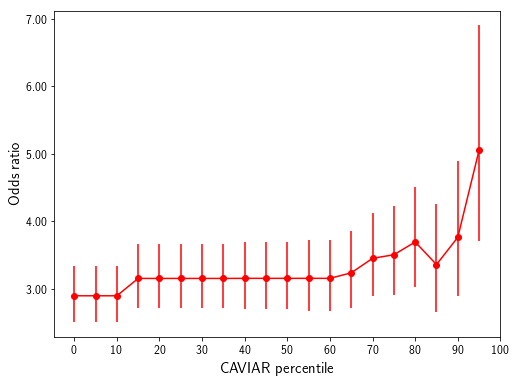

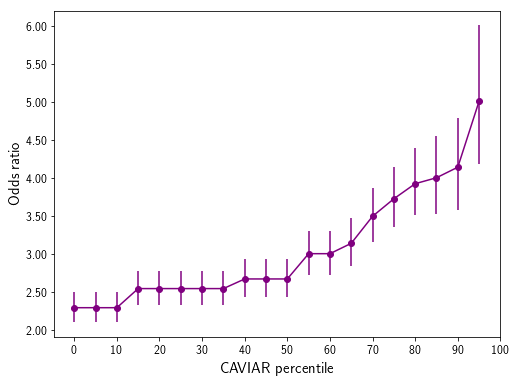

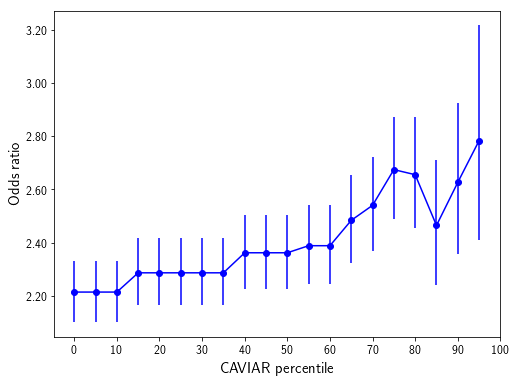

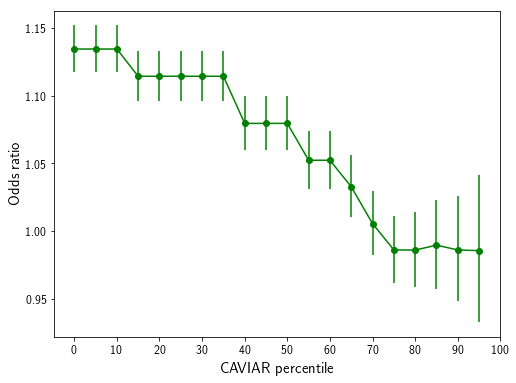

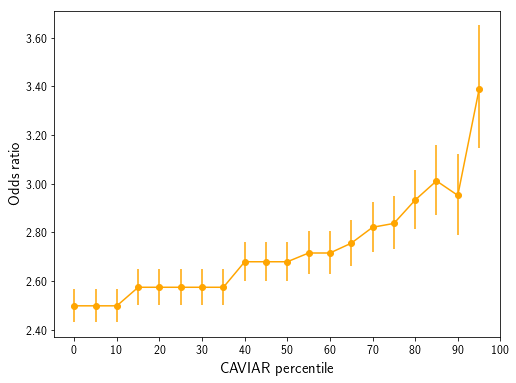

In [5]:
annot_colors = {
    "coding": "red",
    "introns": "green",
    "5utr": "purple",
    "3utr": "blue",
    "hg19_promoter_3kb": "orange",
    "cabili_lincrnas_ucsc": "gold"
}
percentiles_ax = list(percentiles)[:-1]



for j in range(len(all_annot)):
    fig = plt.figure()
    fig.set_size_inches((8, 6))
    ax = fig.add_subplot(111)
    causal_enrich = ([annotenrich_by_cutoff[i]["odds.causal"].values[j] for i in range(len(percentiles_ax))])
    estr_enrich = ([annotenrich_by_cutoff[i]["odds.estrs"].values[j] for i in range(len(percentiles_ax))])
    causal_errs_low = [causal_enrich[i]-annotenrich_by_cutoff[i]["odds.causal.low"].values[j] for i in range(len(percentiles_ax))]
    causal_errs_high = [annotenrich_by_cutoff[i]["odds.causal.high"].values[j]-causal_enrich[i] for i in range(len(percentiles_ax))]
    color = annot_colors[all_annot[j]]
    #ax.plot(percentiles_ax, causal_enrich, label=all_annot[j].replace("_",""), color=color)
    ax.errorbar(percentiles_ax, causal_enrich, yerr=(causal_errs_low, causal_errs_high), 
                label=all_annot[j].replace("_",""), color=color, marker="o")
    #ax.plot(percentiles_ax, estr_enrich, linestyle="dashed", color=color)
    #ax.axhline(y=0, color="black")
#ax.legend(loc="lower right");
    ax.set_xlabel("CAVIAR percentile", size=15)
    ax.set_ylabel("Odds ratio", size=15)
    ax.set_xticks(np.arange(0, 101, 10))
    ax.set_xticklabels([int(item) for item in ax.get_xticks()], size=12)
    ax.set_yticklabels(["%.2f"% item for item in ax.get_yticks()], size=12);
    if SAVEPLOT: fig.savefig(os.path.join(RESULTSDIR, "SuppFig_CAVSCORE_%s.pdf"%all_annot[j]))


In [6]:
# Table of coding eSTRs
coding_causal = pd.merge(estrs[estrs["score"]>=MIN_CAUSAL_SCORE], ref[ref["coding"]>0][["chrom","str.start"]], on=["chrom","str.start"])[["chrom","str.start","gene.name","str.motif.forward","score","tissue_info"]]
coding_causal.sort_values("score", ascending=False)


,chrom,str.start,gene.name,str.motif.forward,score,tissue_info
9,chr3,40503521,RPL14,CTG,0.999949,Adipose-Subcutaneous_-0.30_0.99_8.815288504533...
2,chr14,24769850,DHRS1,AGG,0.939847,Adipose-Subcutaneous_-0.39_0.90_2.255004940304...
0,chr11,6411931,SMPD1,CGCTGG,0.837987,Artery-Aorta_0.23_0.25_0.0013303329781781071;A...
8,chr2,25384460,POMC,CTG,0.680394,Adipose-Subcutaneous_0.31_0.21_1.6666999027483...
3,chr15,90320121,MESP2,AGGGGC,0.624117,Nerve-Tibial_0.26_0.62_2.7222709420402805e-05
5,chr16,71956507,IST1,ATGCCC,0.611302,Artery-Aorta_0.27_0.61_0.00015799954729267098
4,chr16,12009506,GSPT1,CCG,0.551410,Adipose-Subcutaneous_0.23_0.55_0.0001920803922...
7,chr19,55790887,HSPBP1,CCG,0.548793,Adipose-Subcutaneous_-0.28_0.14_2.709559228611...
10,chr3,52027854,RPL29,CCTTGG,0.527178,Adipose-Subcutaneous_-0.30_0.02_7.041994214641...
6,chr19,50093218,SCAF1,ACCCCC,0.515418,WholeBlood_-0.24_0.52_3.1594205114052366e-05


In [7]:
# How many FM-eSTRs in introns/intergenic
c = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
x = pd.merge(c, ref, on=["chrom","str.start"])
print(x[(x["introns"]>=1) & (x["coding"]+x["5utr"]+x["3utr"]+x["hg19_promoter_3kb"]==0)][["chrom","str.start","gene"]].drop_duplicates().shape[0])
print(x[(x["introns"]+x["coding"]+x["5utr"]+x["3utr"]+x["hg19_promoter_3kb"])==0][["chrom","str.start","gene"]].drop_duplicates().shape[0])
print(x[["chrom","str.start","gene"]].drop_duplicates().shape[0])

702
422
1420


/usr/lib/python3.4/site-packages/ipykernel_launcher.py:77: RuntimeWarning: invalid value encountered in double_scalars
/usr/lib/python3.4/site-packages/ipykernel_launcher.py:76: RuntimeWarning: invalid value encountered in double_scalars


,annot,dir.causal,dir.estrs,num.causal,num.estrs,num.total,odds.causal,odds.causal.high,odds.causal.low,odds.estrs,p.dir.causal,p.dir.estrs,pval.causal,pval.estrs
92,CCCCGG,0.750000,0.583333,4,12,20,22.313045,39.050099,12.749570,6.957684,0.625000,0.774414,6.377768e-05,2.944817e-05
90,CCCCCG,0.666667,0.600000,3,10,23,13.377669,24.861459,7.198372,3.567545,1.000000,0.753906,2.052794e-03,3.686123e-03
79,AGGGC,1.000000,0.727273,3,11,29,10.290012,18.944723,5.589121,2.834206,0.250000,0.226563,4.031022e-03,1.159925e-02
91,CCCCG,0.666667,0.529412,3,17,35,8.360226,15.300731,4.567976,4.381330,1.000000,1.000000,6.873090e-03,2.911796e-05
95,CCG,0.571429,0.597015,14,67,195,6.944679,9.177102,5.255315,2.431161,0.790527,0.142071,5.204437e-08,2.734228e-08
71,AGC,0.285714,0.265625,7,64,236,2.729452,4.009863,1.857896,1.727245,0.453125,0.000227,1.716641e-02,3.206435e-04
89,C,0.600000,0.530928,20,194,943,1.942260,2.438803,1.546813,1.202640,0.503445,0.429747,6.974153e-03,2.597838e-02
75,AGG,0.166667,0.458824,6,85,372,1.461104,2.207072,0.967266,1.374563,0.218750,0.515426,3.158417e-01,1.180651e-02
12,AAAG,0.421053,0.478417,19,278,1389,1.237649,1.561766,0.980797,1.162162,0.647606,0.509496,3.649344e-01,2.847722e-02
17,AAAT,0.438202,0.510000,89,1400,6662,1.219293,1.361510,1.091931,1.249368,0.289096,0.470550,8.100958e-02,1.867227e-12


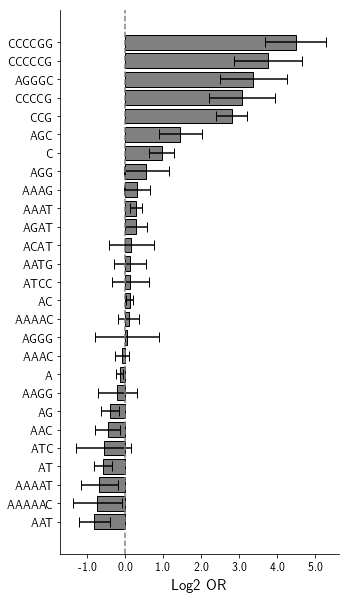

In [8]:
# Motif enrichment - FM-eSTRs vs. all analyzed STRs
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

motifs = ref.groupby("motif", as_index=False).agg({"str.start": len})
motifs = motifs[motifs["motif"] != "ACACAC"]
motifs = list(motifs[motifs["str.start"]>=10]["motif"])
ref_motif = ref[["chrom","str.start","motif"]].copy()
ref_motif["annot"] = ref_motif["motif"]
motif_enrich_all = GetEnrichments(ref_motif, estrs, causal, motifs, annot_col=True)
motif_enrich_all = motif_enrich_all[motif_enrich_all["num.causal"]>=3]

fname = os.path.join(RESULTSDIR, "Figure2_Motifs.pdf")
PlotEnrich(motif_enrich_all.sort_values("odds.causal", ascending=True), size=(5, 10), fname=fname)

motif_enrich_all = motif_enrich_all.sort_values("odds.causal", ascending=False)
motif_enrich_all

In [9]:
# Motif enrichment - FM-eSTRs vs. eSTRs
#causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

#motifs = ref.groupby("motif", as_index=False).agg({"str.start": len})
#motifs = motifs[motifs["motif"] != "ACACAC"]
#motifs = list(motifs[motifs["str.start"]>=10]["motif"])
#ref_motif = ref[["chrom","str.start","motif"]].copy()
#ref_motif["annot"] = ref_motif["motif"]
#ref_motif_estrs = pd.merge(ref_motif, estrs[["chrom","str.start"]].drop_duplicates(), on=["chrom","str.start"])
#motif_enrich_vsE = GetEnrichments(ref_motif_estrs, estrs, causal, motifs, annot_col=True)
#motif_enrich_vsE = motif_enrich_vsE[motif_enrich_vsE["num.causal"]>=3]

#fname = os.path.join(RESULTSDIR, "Figure2_Motifs_vseSTRs.pdf")
#PlotEnrich(motif_enrich_vsE.sort_values("odds.causal", ascending=True), size=(5, 10), fname=fname)

#motif_enrich_all = motif_enrich_vsE.sort_values("odds.causal", ascending=False)
#motif_enrich_all

# Scratch below

In [10]:
# Direction of effect
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]

print("all estrs")
print(sum(estrs["beta"]>0)*1.0/estrs.shape[0])
print(scipy.stats.binom_test(sum(estrs["beta"]>0), estrs.shape[0]))
print("causal estrs")
print(sum(causal["beta"]>0)*1.0/causal.shape[0])
print(scipy.stats.binom_test(sum(causal["beta"]>0), causal.shape[0]))

all estrs
0.5053392070484581
0.07299831413588215
causal estrs
0.5014084507042254
0.9365497587085088


In [11]:
# Break down of period lengths in causal FM-eSTRs
causal = estrs[estrs["score"]>=MIN_CAUSAL_SCORE]
for period in range(1, 7):
    print(period)
    print(causal[causal["motif"].apply(len)==period].shape[0]*1.0/causal.shape[0])

1
0.3619718309859155
2
0.33380281690140845
3
0.048591549295774646
4
0.18169014084507043
5
0.04507042253521127
6
0.028873239436619718
